In [214]:
import polars as pl
from itertools import combinations
from collections import Counter, defaultdict
import networkx as nx
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from community import community_louvain
import seaborn as sns
from nltk import bigrams as nltk_bigrams
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import MWETokenizer
import nltk
from scipy.stats import chi2
from nltk.corpus import stopwords
from functools import lru_cache
from wordcloud import WordCloud
import random

sns.set_style("darkgrid")
nltk.download('stopwords')
nltk.download('wordnet')

np.random.seed(42)
random.seed(42)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\aneas\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Final project - Computational Social Science (02476)

> Data is available [here](https://amazon-reviews-2023.github.io/)

## 0. Table of Contents  
[1. Motivation](#1-motivation)  
[2. Statistics](#2-statistics)  
 [2.1 Process meta data](#21-process-meta-data)  
 [2.2 Process review data](#22-process-review-data)  
 [2.3 Dataset statistics](#23-dataset-statistics)  
[3. Analysis](#3-analysis)  
 [3.1 Network](#31-network)  
 [3.2 Graph](#32-graph)  
 [3.3 Community detection](#33-community-detection)  
 [3.4 Preparing text](#34-preparing-text)  
 [3.5 Tokens](#35-tokens)  
 [3.6 TF-IDF](#36-tf-idf)  
 [3.7 Word clouds](#37-word-clouds)  
[4. Discussion](#4-discussion)

## 1. Motivation

This project uses an Amazon movie and TV review dataset. It is about 8.2GB for the main dataset and about 1.3GB for the meta dataset. It contains different types of physical media from Amazons web shop and digital streaming from Prime video. The media contains not only movies, documentaries and TV series but also a diverse range of video content, such as cookbooks and fitness programs. The main features for this projects will be:

- "title", movie or TV title for product
- "asin", unique internal Amazon product id
- "parent_asin", internal Amazon product id that covers small product variations in product
- "user_id", Amazon customers who have reviewed a product
- "text", review of a product
- "verified_purchase", Amazon has verified the review if the user has bought the product

The dataset was choosen as it was a large comprehensive dataset of movies and other media with title, users and reviews. Grouping and defining movies and TV in an alternative way then standard genres was the goal of this project. By using graph theory it will discover if there is any structure in the way people consume media or if peoples taste are to diverse. This also creates an opportunity for consumers to draw inspiration for movies and TV from clusters similar to their own taste or perhaps discover new things to watch based on word clouds. 

### Constants and function definitions

In [215]:
REVIEW_DATA_FILE = 'dataset/Movies_and_TV.jsonl'
META_DATA_FILE = "dataset/meta_Movies_and_TV.jsonl"
EXTENDED_META_DATA_FILE = "dataset/meta_Movies_and_TV_extended.jsonl"

## 2. Statistics

Initial processing was removing putting together meta data with main dataset and making sure all parent asin and asin points all data points that was missing a title and everything in brackets was removed from the titles as that was from type of media or different edition. This was done as all media with the same title was then made to point to the same parent asin to remove duplicates from same series or different editions of same movies. The dataset consists of 748.236 movies and TV before filtering and 313.988 after removing duplicates. Reviews are only filtered by "verified_purchase" to only include actual purchases and avoid spam reviews. It results in 1.641.575 reviews. 

### 2.1 Process meta data

In [216]:
schema = {
    "title": pl.Utf8,
    "average_rating": pl.Float64,
    "rating_number": pl.Int64,
    "description": pl.List(pl.Utf8),
    "price": pl.Utf8,
    "categories": pl.List(pl.Utf8),
    "details": pl.Struct([
        pl.Field("Content advisory", pl.List(pl.Utf8)),
    ]),
    "parent_asin": pl.Utf8,
}

df_meta_1 = pl.read_ndjson(META_DATA_FILE, schema=schema).rename({"parent_asin": "asin"})
df_meta_2 = pl.read_ndjson(EXTENDED_META_DATA_FILE, schema=schema).rename({"parent_asin": "asin"})

df_meta = pl.concat([df_meta_1, df_meta_2])

# Map prices
df_meta = df_meta.with_columns(
    pl.col("price")
    .str.extract(r"([0-9]+(?:\.[0-9]+)?)", 1)
    .cast(pl.Float64)
    .fill_null(-1)
)

# Map title
df_meta = df_meta.with_columns(
    pl.col("title")
        .str.normalize("NFKC")
        .str.replace_all(r"(?i)\b3-?d\b", "", literal=False)
        .str.replace_all(r"\[.*?\]", "", literal=False)
        .str.replace_all(r"\(.*?\)", "", literal=False)
        .str.replace_all(r":\s*Season\s*\d+", "", literal=False) # Group all seasons
        .str.strip_chars()
        .alias("title")
)

# Map description
df_meta = df_meta.with_columns(
    pl.when(
        pl.col("description").is_null() |
        (pl.col("description").list.eval(pl.element()).list.len() == 0)
    )
    .then(pl.lit([""]).cast(pl.List(pl.Utf8)))
    .otherwise(pl.col("description"))
    .alias("description")
)

df_meta = df_meta.with_columns(
    pl.col("description").list.get(0).alias("description") # TODO GET THE LONGEST DESCRIPTION
)

df_meta = df_meta.with_columns(
    pl.col("description").str.len_chars().alias("desc_len")
)

# Map Content advisory
df_meta = df_meta.with_columns(
    pl.struct(["details"]).map_elements(
        lambda s: s["details"]["Content advisory"] if s["details"] and "Content advisory" in s["details"] else [],
        return_dtype=pl.List(pl.Utf8)
    ).alias("details")
).rename({"details": "content_advisory"})

total_meta_rows = df_meta.height
print(f"There are {total_meta_rows} rows of metadata")

df_meta = df_meta.filter(~pl.col("title").is_null())

print(f"After filtering there are {total_meta_rows - df_meta.height} rows of metadata")

df_meta.limit(3)

There are 748236 rows of metadata
After filtering there are 313988 rows of metadata


title,average_rating,rating_number,description,price,categories,content_advisory,asin,desc_len
str,f64,i64,str,f64,list[str],list[str],str,u32
"""Glee""",4.7,2004,"""Entering its fourth season, th…",22.39,"[""Comedy"", ""Drama"", … ""Music Videos and Concerts""]","[""Violence"", ""substance use"", … ""sexual content""]","""B00ABWKL3I""",396
"""One Perfect Wedding""",3.0,6,"""With her book tour in two week…",-1.0,"[""Comedy"", ""Drama"", ""Romance""]",[],"""B09WDLJ4HP""",219
"""How to Make Animatronic Charac…",5.0,7,"""Product Description""",64.99,"[""Movies & TV"", ""Genre for Featured Categories"", ""Special Interests""]",[],"""B00AHN851G""",19


In [217]:
best_per_title = (
    df_meta.sort(["desc_len", "rating_number"], descending=[True, True])
    .group_by("title")
    .agg([
        pl.col("asin").unique().alias("asins"),
        pl.first("asin").alias("asin"), 
        pl.first("average_rating"),
        pl.first("rating_number"),
        pl.first("description"),
        pl.first("price"),
        pl.first("categories"),
        pl.first("content_advisory")
    ])
    .with_columns(
        pl.col("asins").list.len().alias("num_asins")
    )
)
print(best_per_title.height)
best_per_title.sort("num_asins", descending=True).limit(3)

319288


title,asins,asin,average_rating,rating_number,description,price,categories,content_advisory,num_asins
str,list[str],str,f64,i64,str,f64,list[str],list[str],u32
"""Charlie Rose""","[""B000KC8NHA"", ""B000HBL8BC"", … ""B000GAKSNS""]","""B000IU34D2""",5.0,1,"""First, Dame Joan Sutherland sp…",-1.0,"[""Movies & TV"", ""Charlie Rose Store"", ""All Titles""]",[],65
"""The Walking Dead""","[""B00BKVK0MG"", ""6303487696"", … ""B005RUUUAI""]","""B005LAJ22Q""",4.8,7916,"""When the world is ravaged by a…",18.98,"[""Movies & TV"", ""Boxed Sets"", ""Television""]",[],59
"""Cinderella""","[""6301816080"", ""B000247Y1C"", … ""B0007Z9R7A""]","""B00V6C5Z0Q""",4.7,1819,"""The story of “Cinderella” foll…",7.99,"[""Movies & TV"", ""Walt Disney Studios Home Entertainment"", ""All Disney Titles""]",[],58


In [218]:
movie_attributes = (
    best_per_title.select([
        pl.col("title"),
        pl.col("asins"),
        pl.col("average_rating"),
        pl.col("price")
    ]).explode("asins")
    .rename({"asins": "asin"})
    .sort("title", nulls_last=True)
    .unique(subset=["asin"], keep="first")
)

movie_attributes.limit(3)    

title,asin,average_rating,price
str,str,f64,f64
"""Orny Adams: More Than Loud""","""B077SQM95L""",4.9,-1.0
"""The Invisible Man's Revenge VH…","""6303129013""",4.1,23.99
"""World War 1: The Killing Field…","""B000HEWH2I""",4.4,-1.0


In [219]:
asin_map = (
    best_per_title
      .select(["asin", "asins"])
      .explode("asins")
      .rename({
        "asin": "canon_asin",
        "asins": "orig_asin"
      })
)
asin_map.height

434248

### 2.2 Process review data

In [ ]:
filtered_df = (pl.scan_ndjson(REVIEW_DATA_FILE)
    .filter(pl.col('verified_purchase'))
    .filter(pl.col('helpful_vote').gt(0))
    .drop(['images', 'verified_purchase', 'asin', 'helpful_vote', 'title'])
    .rename({'parent_asin': 'asin'})
    .collect()
    .join(asin_map, left_on="asin", right_on="orig_asin", how="inner")
    .drop(["asin"])
    .rename({"canon_asin": "asin"})
)
print(f"Number of ratings: {filtered_df.height}")
filtered_df.limit(1)

### 2.3 Dataset statistics

In [ ]:
filtered_df.head(3)

rating,text,user_id,timestamp,asin,community
f64,str,str,i64,str,i64
5.0,"""This DVD was GREAT! I am a st…","""AGXVBIUFLFGMVLATYXHJYL4A5Q7Q""",1146713492000,"""B0009BXO3K""",688
3.0,"""this item was canceled. . . .n…","""AEFKF6R2GUSK2AWPSWRR4ZO36JVQ""",1556496429981,"""B000PIU2A0""",null
5.0,"""I grew up with this one. could…","""AEFKF6R2GUSK2AWPSWRR4ZO36JVQ""",1364088518000,"""B001JNNDRY""",21


In [ ]:
print("Number of unique movies and TV: ", filtered_df.select(pl.col("asin")).unique().height)
print("Number of reviews: ", filtered_df.height)
print("Number of unique reviewers: ", filtered_df.select(pl.col("user_id")).unique().height)

Number of unique products:  183024
Number of reviews:  1641575
Number of unique reviewers:  955476


## 3. Analysis

NetworkX will be the main tool for graph theory after a weighted edge list has been created using Polars and a custom function. The network was found to have [MISSING!!!] nodes and [MISSING!!!] edges after only included edges with a weight of 3 or higher [WHY IS THIS THRESHOLD CHOSEN!!!]. This is a not fully connected network with a density of [MISSING!!!] but that is after removing low weighted edges. The network has a modularity of [MISSING!!!] which is very high and it should indicate that there are some distinct communites. [LOUVAIN CLUSTERING, THEORY AND SOME FORMULAS]

NLTK will be the main tool for natural language processing. "text" which are the reviews is tokenized and stemmed. It is then cleaned of symbols, stop words with the addition of some commen and nondescriptive tokens, such as "movi", "film", "episod" and "season". The tokens will then be retokenized using bigrams to improve contextual understanding. TF-IDF is computed for the words in the each cluster to find the unique keywords that defines each cluster. They are then displayed in word clouds. 

### 3.1 Network

In [ ]:
def generate_edge_list():
    grouped = (
        filtered_df
        .group_by("user_id")
        .agg(pl.col("asin").unique().alias("asins"))
        .filter(pl.col("asins").list.len() > 1)
    )

    counter = Counter()

    for asins in tqdm(grouped["asins"], desc="Reviewer"):
        counter.update(tuple(sorted(pair)) for pair in combinations(asins, 2))

    return [(a, b, count) for (a, b), count in counter.items()]

In [ ]:
movie_edgelist = generate_edge_list()
len(movie_edgelist)

Reviewer: 100%|██████████| 221614/221614 [00:16<00:00, 13722.20it/s]


8532787

In [ ]:
Counter((w for _, _, w in movie_edgelist))

Counter({1: 8345819,
         2: 160980,
         3: 18125,
         4: 4481,
         5: 1545,
         6: 733,
         7: 378,
         8: 205,
         9: 147,
         10: 83,
         11: 73,
         12: 49,
         13: 36,
         17: 18,
         14: 17,
         19: 16,
         16: 16,
         15: 15,
         18: 8,
         25: 6,
         21: 5,
         23: 4,
         20: 4,
         26: 4,
         27: 3,
         22: 3,
         35: 2,
         24: 2,
         84: 1,
         31: 1,
         75: 1,
         83: 1,
         40: 1,
         39: 1,
         50: 1,
         30: 1,
         79: 1,
         32: 1})

### 3.2 Graph

The graph is created from the weighted

In [ ]:
WEIGHT_THRESHOLD = 3
weighted_movie_edge = [(a, b, w) for (a, b, w) in movie_edgelist if w >= WEIGHT_THRESHOLD]
len(weighted_movie_edge)

25988

In [ ]:
filtered_df = filtered_df.fill_null("")
attributes = ["title", "average_rating", "price"]
df_attrs = movie_attributes.select(["asin"] + attributes)
attr_dict = {row[0]: dict(zip(attributes, row[1:])) for row in df_attrs.rows()}

In [ ]:
G = nx.Graph()
G.add_weighted_edges_from(weighted_movie_edge)
nx.set_node_attributes(G, attr_dict)

In [ ]:
len(G.nodes()), len(G.edges())

(10897, 25988)

In [ ]:
degrees = [d for _, d in G.degree()]

np.mean(degrees)

4.769753143066899

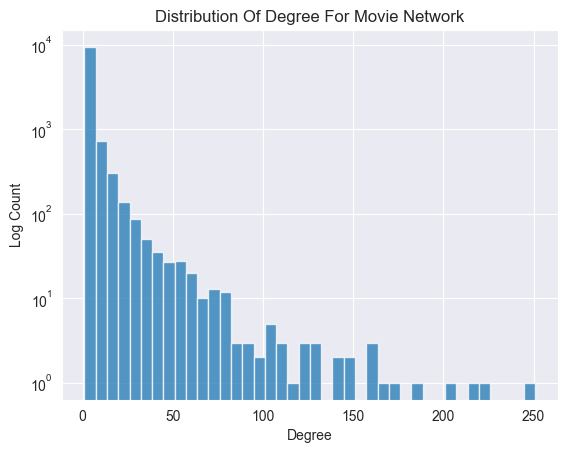

In [ ]:
X = list(dict(G.degree).values())
plt.yscale("log")
plt.title("Distribution Of Degree For Movie Network")
plt.xlabel("Degree")
plt.ylabel("Log Count")
plt.hist(X, 40, alpha=0.75); 

### 3.3 Community detection

In [ ]:
def community_modularity(G, c, L):
    s = G.subgraph(c)
    L_c = s.number_of_edges()
    k_c = sum(dict(s.degree()).values())
    M_c = L_c / L - (k_c / (2 * L)) ** 2
    return M_c

def modularity(G, partitions):
    L = G.number_of_edges()
    return sum((community_modularity(G, c, L) for c in partitions))

In [ ]:
def louvain_partitions(G):
    np.random.seed(42)
    random.seed(42)
    partition = community_louvain.best_partition(G, randomize=False, resolution=1)
    groups = defaultdict(set)
    for node, comm in partition.items():
        groups[comm].add(node)
    return list(groups.values())

In [ ]:
communities = louvain_partitions(G)
Q = modularity(G, communities)
len(communities), Q

(1417, 0.7660709526038777)

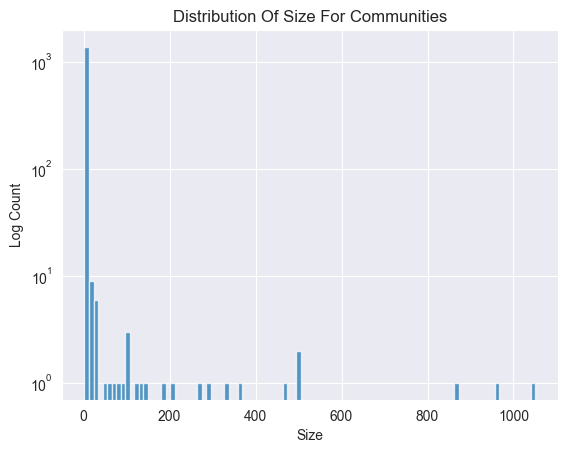

In [ ]:
X = list(map(len, communities))
plt.yscale("log")
plt.title("Distribution Of Size For Communities")
plt.xlabel("Size")
plt.ylabel("Log Count")
plt.hist(X, 100, alpha=0.75);
# Counter(X)

In [ ]:
# Adding community labels to the df
movie_to_community = {
    movie_id: i
    for i, com in enumerate(communities)
    for movie_id in com
}

community_df = pl.DataFrame([
    {"asin": k, "community": v}
    for k, v in movie_to_community.items()
])

if "community" in filtered_df.columns:
    filtered_df = filtered_df.drop("community")

filtered_df = filtered_df.join(community_df, on="asin", how="left")
filtered_df = filtered_df.fill_null("")
filtered_df.limit(2)

rating,text,user_id,timestamp,asin,community
f64,str,str,i64,str,i64
5.0,"""This DVD was GREAT! I am a st…","""AGXVBIUFLFGMVLATYXHJYL4A5Q7Q""",1146713492000,"""B0009BXO3K""",688
3.0,"""this item was canceled. . . .n…","""AEFKF6R2GUSK2AWPSWRR4ZO36JVQ""",1556496429981,"""B000PIU2A0""",null


In [ ]:
movie_attributes = (
    best_per_title
      .select(["title", "asins", "average_rating", "price"])
      .explode("asins")
      .rename({"asins":"asin"})
      .unique(subset=["asin"])
      .join(community_df, on="asin", how="left")
)

attributes = ["title", "average_rating", "price", "community"]
df_attrs = movie_attributes.select(["asin"] + attributes)
attr_dict = {row[0]: dict(zip(attributes, row[1:])) for row in df_attrs.rows()}
nx.set_node_attributes(G, attr_dict)
nx.write_gexf(G, "graph.gexf")

### 3.4 Preparing text

In [24]:
filtered_df.filter(pl.col("community").is_null()).height

981313

In [25]:
filtered_df = filtered_df.filter(pl.col("community").is_not_null()) # Filter reviews that is not part of community - Removed with weight threshold

In [26]:
sum(list(map(len, communities))), len(G.nodes)

(10897, 10897)

In [27]:
# size of each community
community_sizes = (
    filtered_df
    .group_by("community")
    .agg(pl.col("asin").n_unique().alias("community_size"))
    .sort("community_size", descending=True)
)

community_sizes.limit(10)

community,community_size
i64,u32
7,1033
6,956
4,760
5,701
17,526
15,505
3,364
38,286
0,221


### 3.5 Tokens

In [ ]:
lemmatizer = WordNetLemmatizer()

custom = {"film","movie","season","episode","3d","bluray","like"}
stop_words = set(stopwords.words("english")) | custom

stop_lems = {lemmatizer.lemmatize(w) for w in stop_words}

@lru_cache(maxsize=20000)
def cached_lems(word):
    return lemmatizer.lemmatize(word)

def tokenize(tokens):
    out = []
    for t in tokens:
        s = cached_lems(t)
        if s not in stop_lems: out.append(s)
    return out

def bigramify(tokens):
    return list(nltk_bigrams(tokens))

In [29]:
filtered_df = filtered_df.with_columns(
    pl.col("text")
      .str.normalize("NFKC")
      .str.to_lowercase()
      .str.replace_all(r"<br\s*/?>", "", literal=False)
      .str.replace_all(r"\bblu[\s-]?ray\b", "bluray", literal=False)
      .str.replace_all(r"\bmovie\b|[^A-Za-z0-9 ]", "")
      .str.replace_all(r"\s+", " ", literal=False)
      .str.strip_chars()           
      .str.split(" ")  
      .map_elements(tokenize, return_dtype=pl.List(pl.Utf8))
      .alias("tokens")
)

In [30]:
filtered_df = filtered_df.with_columns(
    bigrams=pl.col("tokens").map_elements(bigramify, return_dtype=pl.List(pl.List(pl.Utf8)))
)
filtered_df.limit(5)

rating,text,user_id,timestamp,asin,community,tokens,bigrams
f64,str,str,i64,str,i64,list[str],list[list[str]]
5.0,"""This DVD was GREAT! I am a st…","""AGXVBIUFLFGMVLATYXHJYL4A5Q7Q""",1146713492000,"""B0009BXO3K""",245,"[""dvd"", ""great"", … ""give""]","[[""dvd"", ""great""], [""great"", ""stay""], … [""love"", ""give""]]"
5.0,"""I grew up with this one. could…","""AEFKF6R2GUSK2AWPSWRR4ZO36JVQ""",1364088518000,"""B001JNNDRY""",17,"[""grew"", ""one"", … ""collect""]","[[""grew"", ""one""], [""one"", ""couldnt""], … [""collect"", ""collect""]]"
4.0,"""This is a fun, colorful, enter…","""AFWHJ6O3PV4JC7PVOJH6CPULO2KQ""",1399992093000,"""B001JV5BF8""",642,"[""fun"", ""color"", … ""imo62""]","[[""fun"", ""color""], [""color"", ""entertain""], … [""34"", ""imo62""]]"
2.0,"""Classic movie. But I didn't ge…","""AEO4M665ZOCBF7HEFRMTUDHLSB5Q""",1325272496000,"""B07FMQXZBD""",5,"[""classic"", ""didnt"", … ""problem""]","[[""classic"", ""didnt""], [""didnt"", ""get""], … [""month"", ""problem""]]"
4.0,"""This is the best version follo…","""AG35BKPUEUMX7LV5YLOQ5YCQ3GOA""",1514400490306,"""B008UY8FI2""",4,"[""best"", ""version"", … ""station""]","[[""best"", ""version""], [""version"", ""follow""], … [""tv"", ""station""]]"


In [31]:
bigrams = (
    filtered_df
    .select(pl.col("bigrams"))
    .drop_nulls()
    .explode("bigrams")
    .get_column("bigrams")
    .to_list()
)

bigrams = [tuple(bg) for bg in bigrams if isinstance(bg, list) and len(bg) == 2]

filtered_df = filtered_df.drop("bigrams")

In [32]:
def find_collocations(bigrams, min_count=50, p_threshold=0.001):
    bigram_counts = Counter(bigrams)
    first_counts = Counter()
    second_counts = Counter()
    for (w1, w2), cnt in bigram_counts.items():
        first_counts[w1] += cnt
        second_counts[w2] += cnt

    N = len(bigrams)
    items = list(bigram_counts.items())
    bgs, nii = zip(*items)
    w1s, w2s = zip(*bgs)

    f = np.fromiter((first_counts[w] for w in w1s), float)
    s = np.fromiter((second_counts[w] for w in w2s), float)
    o = np.array(nii, float)

    nio = f - o
    noi = s - o
    noo = N - (o + nio + noi)

    Eii = f * s / N
    Eio = f * (N - s) / N
    Eoi = (N - f) * s / N
    Eoo = (N - f) * (N - s) / N

    chi2_vals = (o - Eii)**2/Eii + (nio - Eio)**2/Eio + (noi - Eoi)**2/Eoi + (noo - Eoo)**2/Eoo
    p_vals = chi2.sf(chi2_vals, 1)

    mask = (o > min_count) & (p_vals < p_threshold)
    return {bgs[i]: int(o[i]) for i in np.nonzero(mask)[0]}

collocs = find_collocations(bigrams)

In [33]:
tokenizer = MWETokenizer(list(collocs.keys()), separator="_")
filtered_df = filtered_df.with_columns(
    tokens=pl.col("tokens").map_elements(tokenizer.tokenize, return_dtype=pl.List(pl.Utf8))
)

In [34]:
filtered_df.write_ndjson("tokenized_reviews.jsonl")
filtered_df = pl.read_ndjson("tokenized_reviews.jsonl")

In [ ]:
community_docs = (
    filtered_df
    .group_by("community")
    .agg(
        pl.concat_list("tokens").flatten().alias("tokens"), 
        pl.len().alias("num_reviews")
    ).sort("num_reviews", descending=True)
)
top5com = community_docs.limit(20)

In [42]:
top_20_30 = community_docs.slice(20,10)

### 3.6 TF-IDF

In [36]:
def calculate_tf(tokens):
    total = len(tokens)
    counts = Counter(tokens)
    return {word: count / total for word, count in counts.items()}

def calculate_idf(docs: pl.DataFrame) -> dict[str, float]:
    N = docs.height
    df = (
        docs
        .explode("tokens")
        .unique(subset=["community", "tokens"])
        .group_by("tokens")
        .agg(pl.len().alias("df"))
        .with_columns((pl.lit(N) / pl.col("df")).log().alias("idf"))
        .sort("idf", descending=False)
    )
    return dict(zip(df["tokens"].to_list(), df["idf"].to_list()))

def calculate_tf_idf(tf, idf):
    tf_idf = {}
    for word, val in tf.items():
        tf_idf[word] = val * idf[word]
    return tf_idf

In [37]:
idf = calculate_idf(community_docs)

In [38]:
top_5_tf_idf = dict(zip(
    top5com["community"].to_list(),
    [calculate_tf_idf(calculate_tf(toks), idf) for toks in top5com["tokens"].to_list()]
))

In [43]:
top_20_30_tf_idf= dict(zip(
    top_20_30["community"].to_list(),
    [calculate_tf_idf(calculate_tf(toks), idf) for toks in top_20_30["tokens"].to_list()]
))

In [39]:
top_titles = (filtered_df.join(
      movie_attributes.select(["asin","title"]),
      on="asin",
      how="left"
   ).group_by(["community", "title"])
    .agg(pl.len().alias("count"))
    .sort(["community","count"], descending=[False,True])
    .group_by("community")
    .agg(pl.col("title").head(3).alias("top_titles"))
)

top_titles_dict = dict(zip(top_titles["community"].to_list(), top_titles["top_titles"].to_list()))

### 3.7 Word clouds

In [ ]:
def plot_word_clouds_grid(word_freq, top_movies = None, ncols=3, max_title_len=30):
    def truncate_list(ts):
        return [t if len(t)<=max_title_len else t[:max_title_len]+'…' for t in ts]
    
    communities = list(word_freq.keys())
    nrows = -(-len(communities) // ncols)
    fig, axes = plt.subplots(nrows, ncols, figsize=(ncols * 5, nrows * 6))
    axes = axes.flatten()

    for ax, comm in zip(axes, communities):
        cloud = WordCloud(background_color='white', height=500, width=500, colormap="viridis_r", contour_color='black', contour_width=0.5)
        cloud.generate_from_frequencies(word_freq[comm])
        titles = truncate_list(top_movies.get(comm, []))
        ax.imshow(cloud, interpolation='bilinear')
        ax.set_title("\n".join(titles), fontsize=12)
        ax.axis('off')

    for ax in axes[len(communities):]:
        ax.axis('off')

    plt.tight_layout()
    plt.show()

plot_word_clouds_grid(top_5_tf_idf, top_titles_dict) # Plotting is based on tf-idf values and stemmed tokens

### Most negative communties

In [159]:
avg_com_rating = (
    filtered_df
    .group_by("community")
    .agg(pl.col("rating").mean())
    .sort("rating")
)
avg_com_rating

community,rating
i64,f64
367,1.75
601,2.163636
1346,2.186441
1201,2.333333
277,2.5625
…,…
732,5.0
366,5.0
1405,5.0


## 4. Discussion